In [3]:
import pandas as pd

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
lb = pd.read_csv('loan_before.csv')

# 1. 문제정의

<strong>질문 1.</strong> 어떤 요소가 대출금 상환 여부에 가장 큰 영향을 줄까? <br>
<strong>질문 2.</strong> 그 요소들이 상환 여부에 어떤 영향을 줄까?

# 2. 방법론

### 2.1 분석과정

이 질문에 대한 해답을 얻기 위해 해석가능한 머신러닝(xAL)을 활용하였음

<strong>프로세스</strong>

- 1. feature engineering
- 2. 머신러닝 모델을 만든다.
- 3. shap value를 통해 어떤 변수가 가장 큰 영향을 주는지 알아본다.
- 4. 영향을 많이 주는 5개의 변수와 대출금 상환 여부의 관계를 살펴본다.

### 2.2 feature engineering

- AMT_CREDIT에서 AMT_ANNUITY를 나눠 <strong>해당 사람이 몇 개월에 걸쳐 돈을 갚아야 하는지</strong> 변수화

In [95]:
train['AMT_CREDIT_TO_ANNUITY_RATIO'] = train['AMT_CREDIT'] / train['AMT_ANNUITY']
test['AMT_CREDIT_TO_ANNUITY_RATIO'] = test['AMT_CREDIT'] / test['AMT_ANNUITY']

- lb(이전 대출 정보)를 활용해 변수 생성을 시도

<strong>1. ID를 기준으로 groupby 후 평균을 낸다.</strong> <br>
1) AMT_CREDIT(이전 대출금) <br>
2) DAYS_CREDIT(Home credit 대출 기준으로 며칠 전에 또 다른 대출을 진행했는지) <br>
3) CNT_CREDIT_PROLONG(상환 연장을 몇 번 했는지)

<strong>2. ID를 기준으로 groupby 후 개수(ID별로 대출 빈도 수, 해당 사람이 대출을 몇 번 했는지)</strong> <br>

In [108]:
lb.head()

,SK_ID_CURR,DAYS_CREDIT,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,CREDIT_TYPE
0,400486,-2413,0,180000.0,Consumer credit
1,400486,-941,0,40500.0,Credit card
2,400486,-1110,0,114727.5,Consumer credit
3,400486,-2133,0,225000.0,Consumer credit
4,400486,-391,0,142290.0,Consumer credit


In [97]:
lb.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].mean().reset_index()

,SK_ID_CURR,AMT_CREDIT_SUM
0,100026,1.875000e+06
1,100041,6.325424e+04
2,100084,9.810000e+04
3,100088,3.555000e+05
4,100100,6.327487e+05
...,...,...
25707,456153,1.627073e+05
25708,456212,2.726224e+05
25709,456238,1.849170e+05
25710,456253,9.900000e+05


In [98]:
train = pd.merge(train, lb.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].mean(), how='left', on='SK_ID_CURR' )
test = pd.merge(test, lb.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].mean(), how='left', on='SK_ID_CURR' )

In [99]:
train = pd.merge(train, lb.groupby('SK_ID_CURR')['DAYS_CREDIT'].mean(), how='left', on='SK_ID_CURR' )
test = pd.merge(test, lb.groupby('SK_ID_CURR')['DAYS_CREDIT'].mean(), how='left', on='SK_ID_CURR' )

In [100]:
train = pd.merge(train, lb.groupby('SK_ID_CURR')['CNT_CREDIT_PROLONG'].mean(), how='left', on='SK_ID_CURR' )
test = pd.merge(test, lb.groupby('SK_ID_CURR')['CNT_CREDIT_PROLONG'].mean(), how='left', on='SK_ID_CURR' )

In [101]:
train = pd.merge(train, lb.groupby('SK_ID_CURR').size().reset_index().rename(columns={0:'count'}), how='left', on='SK_ID_CURR' )
test = pd.merge(test, lb.groupby('SK_ID_CURR').size().reset_index().rename(columns={0:'count'}), how='left', on='SK_ID_CURR' )

In [102]:
train.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,...,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_TO_ANNUITY_RATIO,AMT_CREDIT_SUM,DAYS_CREDIT,CNT_CREDIT_PROLONG,count
0,162716,0,0.0,0,1,0,101250.0,480060.0,22509.0,Unaccompanied,...,NaN,0.665732,NaN,-139.0,1.0,21.327469,3.150000e+05,-36.000000,0.0,1.0
1,361317,0,0.0,0,1,2,225000.0,237024.0,12231.0,Unaccompanied,...,0.575699,0.535140,0.670652,-957.0,0.0,19.378955,2.067966e+06,-1408.000000,0.0,9.0
2,246925,0,1.0,0,0,0,171000.0,247675.5,26005.5,Unaccompanied,...,0.092273,0.002272,0.154744,-827.0,1.0,9.523966,6.219386e+04,-597.142857,0.0,7.0
3,294331,0,1.0,1,0,0,225000.0,180000.0,9000.0,Unaccompanied,...,0.221815,0.120444,NaN,-569.0,2.0,20.000000,2.770443e+04,-1545.000000,0.0,1.0
4,152173,0,0.0,0,1,0,180000.0,337500.0,12852.0,Unaccompanied,...,NaN,0.722415,0.723837,-1544.0,4.0,26.260504,1.068750e+05,-2696.000000,0.0,1.0


In [103]:
test.head()

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,...,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_TO_ANNUITY_RATIO,AMT_CREDIT_SUM,DAYS_CREDIT,CNT_CREDIT_PROLONG,count
0,333864,1.0,1,0,1,225000.0,315000.0,16002.0,Unaccompanied,Commercial associate,...,NaN,0.664203,0.179822,-1116.0,0.0,19.685039,2.356490e+06,-1590.50,0.0,2.0
1,253018,0.0,0,0,1,90000.0,225000.0,11250.0,Unaccompanied,Working,...,0.399164,0.259984,NaN,-982.0,0.0,20.000000,3.932777e+04,-2252.25,0.0,4.0
2,360625,1.0,0,0,0,202500.0,888840.0,37494.0,Unaccompanied,Working,...,0.212372,0.470406,0.234015,-2052.0,2.0,23.706193,6.357150e+04,-1337.60,0.0,5.0
3,287255,1.0,1,1,2,202500.0,168102.0,20079.0,Unaccompanied,Working,...,0.823040,0.648610,0.304672,-2420.0,3.0,8.372030,3.420000e+06,-469.50,0.0,2.0
4,281149,0.0,0,1,0,306000.0,734166.0,49261.5,Unaccompanied,Working,...,NaN,0.655703,0.315472,-1511.0,2.0,14.903444,1.378325e+05,-1397.40,0.0,5.0


In [104]:
train.dtypes

SK_ID_CURR                       int64
TARGET                           int64
CODE_GENDER                    float64
FLAG_OWN_CAR                     int64
FLAG_OWN_REALTY                  int64
CNT_CHILDREN                     int64
AMT_INCOME_TOTAL               float64
AMT_CREDIT                     float64
AMT_ANNUITY                    float64
NAME_TYPE_SUITE                 object
NAME_INCOME_TYPE                object
NAME_EDUCATION_TYPE             object
NAME_HOUSING_TYPE               object
REGION_POPULATION_RELATIVE     float64
DAYS_BIRTH                       int64
DAYS_EMPLOYED                  float64
DAYS_ID_PUBLISH                  int64
OWN_CAR_AGE                    float64
CNT_FAM_MEMBERS                float64
HOUR_APPR_PROCESS_START          int64
ORGANIZATION_TYPE               object
EXT_SOURCE_1                   float64
EXT_SOURCE_2                   float64
EXT_SOURCE_3                   float64
DAYS_LAST_PHONE_CHANGE         float64
AMT_REQ_CREDIT_BUREAU_YEA

- 해당 프로젝트의 목적은 모델 해석이기 때문에, 이에 방해를 주는 변수 모두 삭제처리함

<strong>제거한 변수 목록</strong> <br>
<ul>
<li>CODE_GENDER : 범주형 변수 </li>
<li>FLAG_OWN_CAR : 범주형 변수 </li>
<li>FLAG_OWN_REALTY : 범주형 변수</li>
<li>NAME_TYPE_SUITE : 범주형 변수</li>
<li>NAME_INCOME_TYPE : 범주형 변수 </li>
<li>NAME_EDUCATION_TYPE : 범주형 변수</li>
<li>NAME_HOUSING_TYPE : 범주형 변수 </li>
<li>ORGANIZATION_TYPE : 범주형 변수 </li>
<li>EXT_SOURCE_1 : 변수의 의미를 정확히 모름 </li>
<li>EXT_SOURCE_2 : 변수의 의미를 정확히 모름 </li>
<li>EXT_SOURCE_3 : 변수의 의미를 정확히 모름 </li>
</ul>

In [109]:
del_list = ['CODE_GENDER','FLAG_OWN_REALTY', 'FLAG_OWN_CAR', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE','NAME_HOUSING_TYPE','ORGANIZATION_TYPE','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']

In [106]:
train = train.drop(del_list, axis=1)
test = test.drop(del_list, axis=1)

In [107]:
train

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_TO_ANNUITY_RATIO,AMT_CREDIT_SUM,DAYS_CREDIT,CNT_CREDIT_PROLONG,count
0,162716,0,0,101250.0,480060.0,22509.0,0.009334,-18972,-2174.0,-2256,NaN,2.0,15,-139.0,1.0,21.327469,3.150000e+05,-36.000000,0.0,1.0
1,361317,0,2,225000.0,237024.0,12231.0,0.010032,-11902,-1027.0,-4133,NaN,4.0,3,-957.0,0.0,19.378955,2.067966e+06,-1408.000000,0.0,9.0
2,246925,0,0,171000.0,247675.5,26005.5,0.005144,-13120,-1148.0,-4340,NaN,2.0,10,-827.0,1.0,9.523966,6.219386e+04,-597.142857,0.0,7.0
3,294331,0,0,225000.0,180000.0,9000.0,0.018801,-10240,-1973.0,-1621,12.0,2.0,12,-569.0,2.0,20.000000,2.770443e+04,-1545.000000,0.0,1.0
4,152173,0,0,180000.0,337500.0,12852.0,0.030755,-21220,NaN,-2870,NaN,1.0,12,-1544.0,4.0,26.260504,1.068750e+05,-2696.000000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,151299,0,0,202500.0,323460.0,25159.5,0.006671,-8568,-1961.0,-1108,16.0,2.0,13,-596.0,0.0,12.856376,5.992780e+05,-343.800000,0.0,5.0
19996,126098,0,0,157500.0,225000.0,13045.5,0.030755,-24489,NaN,-3929,NaN,1.0,11,-521.0,1.0,17.247327,1.253187e+05,-1077.000000,0.0,5.0
19997,344354,0,0,112500.0,835380.0,35523.0,0.020713,-9924,-379.0,-129,NaN,1.0,5,-1.0,NaN,23.516595,NaN,NaN,NaN,NaN
19998,443567,0,0,76500.0,247500.0,12375.0,0.030755,-11885,-749.0,-4313,64.0,2.0,14,-386.0,1.0,20.000000,2.341887e+04,-1970.333333,0.0,3.0


### 2.3 모델링

<strong>모델링을 하기 전, 서로 상관관계가 높은 input 변수를 삭제한다.</strong><br>
이유 : input 변수가 높은 상관성을 띌 때 shap value는 제대로 된 설명력을 발휘하지 못함

In [111]:
input_var = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count']

#### 변수들 간의 상관관계 파악

In [112]:
train[input_var].corr()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_TO_ANNUITY_RATIO,AMT_CREDIT_SUM,DAYS_CREDIT,CNT_CREDIT_PROLONG,count
CNT_CHILDREN,1.000000,0.029879,0.006465,0.023275,-0.033326,0.332123,0.068807,-0.029581,-0.010951,0.883051,-0.009661,-0.006102,-0.036431,-0.022026,0.035864,0.026285,-0.012065,0.002649
AMT_INCOME_TOTAL,0.029879,1.000000,0.366717,0.441573,0.185047,0.066875,-0.041696,0.029519,-0.126551,0.029342,0.092505,-0.040823,0.031593,0.077303,0.241929,-0.013266,0.016117,0.116635
AMT_CREDIT,0.006465,0.366717,1.000000,0.770938,0.092177,-0.047089,-0.085049,0.000988,-0.111244,0.066847,0.047472,-0.070924,-0.037907,0.656337,0.135435,-0.068411,-0.000384,0.046902
AMT_ANNUITY,0.023275,0.441573,0.770938,1.000000,0.127204,0.017106,-0.048381,0.013662,-0.108185,0.073912,0.047113,-0.058709,0.000270,0.111694,0.128144,-0.052613,-0.005724,0.013588
REGION_POPULATION_RELATIVE,-0.033326,0.185047,0.092177,0.127204,1.000000,-0.023276,0.013870,0.000946,-0.088270,-0.025638,0.182730,-0.051167,0.015725,0.003524,0.077984,-0.010819,0.003701,-0.034289
DAYS_BIRTH,0.332123,0.066875,-0.047089,0.017106,-0.023276,1.000000,0.349373,0.266852,-0.015877,0.283729,0.087200,0.080317,-0.073904,-0.097736,0.053205,0.201829,0.028239,-0.063004
DAYS_EMPLOYED,0.068807,-0.041696,-0.085049,-0.048381,0.013870,0.349373,1.000000,0.093421,0.014016,0.032736,0.003502,0.144221,0.003833,-0.087176,-0.018131,0.160521,0.000124,-0.148704
DAYS_ID_PUBLISH,-0.029581,0.029519,0.000988,0.013662,0.000946,0.266852,0.093421,1.000000,0.001141,-0.025311,0.029700,0.089952,-0.039895,-0.020280,0.033384,0.188471,0.022736,-0.100673
OWN_CAR_AGE,-0.010951,-0.126551,-0.111244,-0.108185,-0.088270,-0.015877,0.014016,0.001141,1.000000,-0.039362,-0.082672,0.013561,-0.025423,-0.059224,-0.094781,-0.006665,0.011323,-0.025711
CNT_FAM_MEMBERS,0.883051,0.029342,0.066847,0.073912,-0.025638,0.283729,0.032736,-0.025311,-0.039362,1.000000,-0.011111,-0.029047,-0.019913,0.014088,0.060422,0.006905,-0.013910,0.017717


In [113]:
import seaborn as sns

<AxesSubplot:>

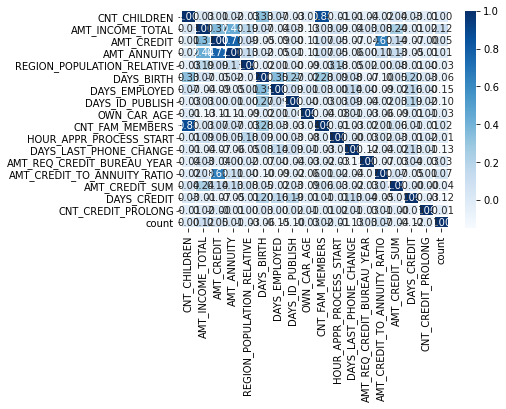

In [124]:
sns.heatmap(data=train[input_var].corr(),annot=True, fmt='.2f' ,linewidth=0.5, cmap='Blues')

#### 높은 상관성을 띄는 변수는 아래와 같다.

- CNT_FAM_MEMBERS & CNT_CHILDREN <br>
- AMT_CREDIT_TO_ANNUITY_RATIO & AMT_CREDIT <br>
- AMT_ANNUITY & AMT_CREDIT

#### 높은 상관성을 띄는 변수 중 하나씩 제거해줘야함 <BR>
기준은 TARGET 값과의 상관성이 낮은 변수를 제거

In [129]:
print(train['CNT_FAM_MEMBERS'].corr(train['TARGET']))
print(train['CNT_CHILDREN'].corr(train['TARGET']))

0.018876651698723254
0.025357359317616786


In [131]:
del train['CNT_FAM_MEMBERS']
del test['CNT_FAM_MEMBERS']

In [135]:
train

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,OWN_CAR_AGE,HOUR_APPR_PROCESS_START,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_TO_ANNUITY_RATIO,AMT_CREDIT_SUM,DAYS_CREDIT,CNT_CREDIT_PROLONG,count
0,162716,0,0,101250.0,22509.0,0.009334,-18972,-2174.0,-2256,NaN,15,-139.0,1.0,21.327469,3.150000e+05,-36.000000,0.0,1.0
1,361317,0,2,225000.0,12231.0,0.010032,-11902,-1027.0,-4133,NaN,3,-957.0,0.0,19.378955,2.067966e+06,-1408.000000,0.0,9.0
2,246925,0,0,171000.0,26005.5,0.005144,-13120,-1148.0,-4340,NaN,10,-827.0,1.0,9.523966,6.219386e+04,-597.142857,0.0,7.0
3,294331,0,0,225000.0,9000.0,0.018801,-10240,-1973.0,-1621,12.0,12,-569.0,2.0,20.000000,2.770443e+04,-1545.000000,0.0,1.0
4,152173,0,0,180000.0,12852.0,0.030755,-21220,NaN,-2870,NaN,12,-1544.0,4.0,26.260504,1.068750e+05,-2696.000000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,151299,0,0,202500.0,25159.5,0.006671,-8568,-1961.0,-1108,16.0,13,-596.0,0.0,12.856376,5.992780e+05,-343.800000,0.0,5.0
19996,126098,0,0,157500.0,13045.5,0.030755,-24489,NaN,-3929,NaN,11,-521.0,1.0,17.247327,1.253187e+05,-1077.000000,0.0,5.0
19997,344354,0,0,112500.0,35523.0,0.020713,-9924,-379.0,-129,NaN,5,-1.0,NaN,23.516595,NaN,NaN,NaN,NaN
19998,443567,0,0,76500.0,12375.0,0.030755,-11885,-749.0,-4313,64.0,14,-386.0,1.0,20.000000,2.341887e+04,-1970.333333,0.0,3.0


In [133]:
print(train['AMT_CREDIT_TO_ANNUITY_RATIO'].corr(train['TARGET']))
print(train['AMT_CREDIT'].corr(train['TARGET']))

-0.024740288335190187
-0.022558430849347857


In [134]:
del train['AMT_CREDIT']
del test['AMT_CREDIT']

In [138]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count'],
      dtype='object')

In [141]:
input_var=['AMT_INCOME_TOTAL',
       'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count']

#### xgboost를 사용하여 모델링 진행

이유 : shap value를 활용하기 위해선 모델이 랜덤포레스트 형태의 tree형 모델이어야 한다. 이중에서 xgboost가 속도가 빠르면서 높은 성능을 유지하기 때문에 xgboost를 선택함

In [139]:
from xgboost import XGBClassifier

In [158]:
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1)
xgb.fit(train[input_var], train['TARGET'])

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[18:47:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### 2.4 shap values 활용

In [159]:
import shap

In [160]:
shap_values = shap.TreeExplainer(xgb).shap_values(train[input_var])

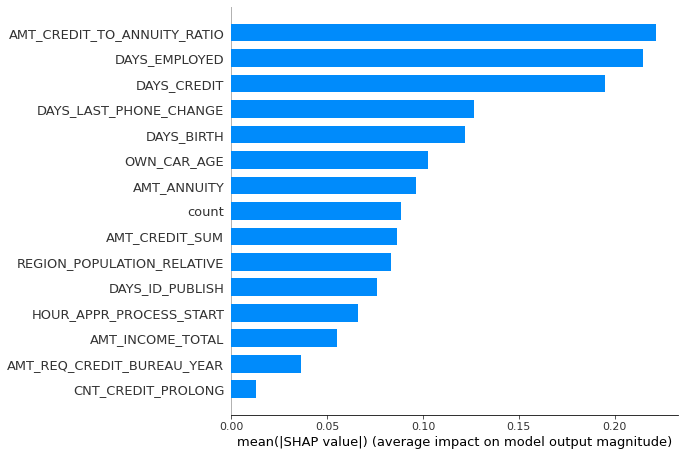

In [161]:
shap.summary_plot(shap_values, train[input_var], plot_type='bar')

#### 시각화 결과, 타겟값에 가장 큰 영향을 미치는 상위 5가지 변수는 다음과 같다.

- AMT_CREDIT_TO_ANNUITY_RATIO
- DAYS_EMPLOYED
- DAYS_CREDIT
- DAYS_LAST_PHONE_CHANGE
- DAYS_BIRTH

### 2.5 영향을 많이 주는 5개 변수와 상환 여부와의 관계를 알아본다.

1. AMT_CREDIT_TO_ANNUITY_RATIO

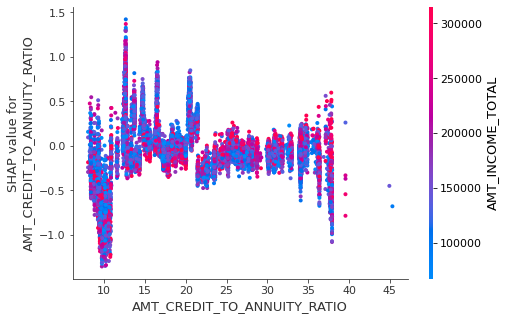

In [149]:
shap.dependence_plot('AMT_CREDIT_TO_ANNUITY_RATIO', shap_values, train[input_var])

대출 상환 기간이 12개월 ~ 20개월 일 때 상환을 잘 못한다. <BR>
반면 12개월 이하, 20개월 이상일 때는 비교적 상환을 잘 한다. 

2. DAYS_EMPLOYED

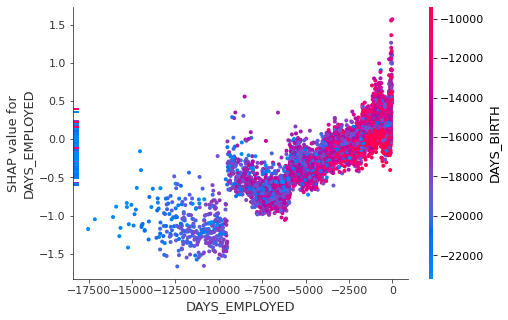

In [162]:
shap.dependence_plot('DAYS_EMPLOYED', shap_values, train[input_var])

취업한 지 오래됐을수록 상환을 잘 한다. <br>
대출일 기준 9000일보다 전에 취업했을 때 상환확률이 급상승한다.

3. DAYS_CREDIT

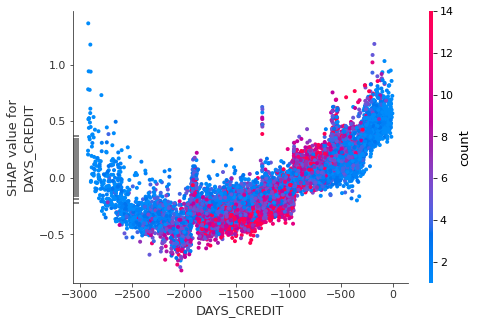

In [153]:
shap.dependence_plot('DAYS_CREDIT', shap_values, train[input_var])

-3000일부터 -2000일까지는 상환 능력이 상승한다. <br>
그 이후부터는 하락한다.

4. DAYS_LAST_PHONE_CHANGE

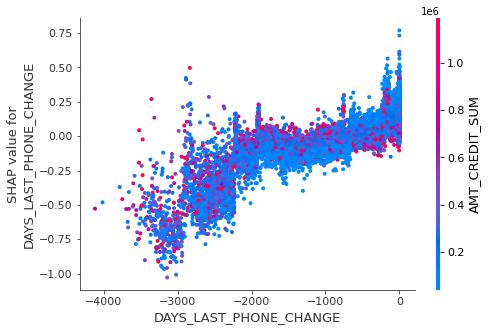

In [155]:
shap.dependence_plot('DAYS_LAST_PHONE_CHANGE', shap_values, train[input_var])

핸드폰을 바꾼 지 오래됐을수록 상환능력이 상승한다.

5. DAYS_BIRTH

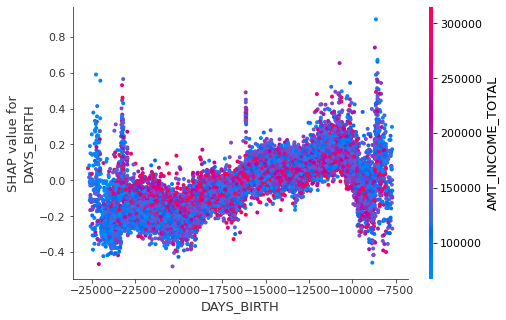

In [157]:
shap.dependence_plot('DAYS_BIRTH', shap_values, train[input_var])

태어난 지 오래됐을수록 상환능력이 상승한다.

# 3. 결론

1. 대출상환기간이 상환여부에 가장 큰 영향을 준다. 해당 변수는 타겟 변수와 비선형적 관계이다.
<br>

2. 주택 보유 여부와 자식의 수는 대출 상환능력에 큰 영향을 끼치지 않는다.
<br>

3. 최근에 취업했을수록, 최근에 대출 받았을수록, 최근에 핸드폰을 바꿨을수록, 나이가 어릴수록 대출금 상환 가능성이 낮다.

### 3.1 시각화

#### DAYS_EMPLOYED, DAYS_CREDIT, DAYS_LAST_PHONE_CHANGE,DAYS_BIRTH의 75%와 25% 비교

In [168]:
group1 = train[(train['DAYS_EMPLOYED'].quantile(0.75) < train['DAYS_EMPLOYED']) &
(train['DAYS_CREDIT'].quantile(0.75)<train['DAYS_CREDIT']) &
(train['DAYS_LAST_PHONE_CHANGE'].quantile(0.75)<train['DAYS_LAST_PHONE_CHANGE']) &
(train['DAYS_BIRTH'].quantile(0.75)<train['DAYS_BIRTH'])]

In [169]:
group2 = train[(train['DAYS_EMPLOYED'].quantile(0.25) > train['DAYS_EMPLOYED']) &
(train['DAYS_CREDIT'].quantile(0.25)>train['DAYS_CREDIT']) &
(train['DAYS_LAST_PHONE_CHANGE'].quantile(0.25)>train['DAYS_LAST_PHONE_CHANGE']) &
(train['DAYS_BIRTH'].quantile(0.25)>train['DAYS_BIRTH'])]

In [179]:
group1['group'] = 1
group2['group'] = 0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [182]:
full = pd.concat([group1, group2])

In [183]:
full

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,OWN_CAR_AGE,HOUR_APPR_PROCESS_START,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_TO_ANNUITY_RATIO,AMT_CREDIT_SUM,DAYS_CREDIT,CNT_CREDIT_PROLONG,count,group
19,148243,0,0,157500.0,29470.5,0.006305,-9946,-694.0,-430,NaN,9,0.0,7.0,20.787296,670500.000000,-291.000000,0.0,1.0,1
97,449339,0,0,139500.0,22122.0,0.018801,-8723,-263.0,-1404,13.0,8,-256.0,1.0,24.410090,402856.500000,-449.666667,0.0,6.0,1
104,244014,0,0,103500.0,14715.0,0.007020,-12172,-634.0,-2351,NaN,14,-5.0,0.0,31.854128,205537.500000,-345.500000,0.0,2.0,1
130,213561,0,2,220500.0,17311.5,0.016612,-10021,-180.0,-2699,20.0,12,-118.0,0.0,26.254224,90000.000000,-204.000000,0.0,1.0,1
187,132571,0,0,112500.0,18927.0,0.018029,-9361,-631.0,-2038,NaN,6,-118.0,2.0,21.305516,119263.500000,-374.250000,0.0,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18513,350380,0,0,157500.0,30645.0,0.046220,-20285,-6106.0,-3830,9.0,17,-2197.0,3.0,25.110132,104065.200000,-1597.500000,0.0,2.0,0
18617,169817,0,0,270000.0,30640.5,0.024610,-20163,-8222.0,-3667,NaN,12,-1812.0,3.0,27.840799,105273.125000,-1713.888889,0.0,18.0,0
19773,357658,0,0,135000.0,22216.5,0.007305,-19808,-3285.0,-3307,NaN,8,-2459.0,0.0,23.463642,443457.500000,-1568.333333,0.0,9.0,0
19783,255934,0,0,382500.0,24403.5,0.025164,-20340,-6993.0,-3798,2.0,16,-1692.0,1.0,34.020284,157494.353226,-1819.451613,0.0,31.0,0


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='group', ylabel='TARGET'>

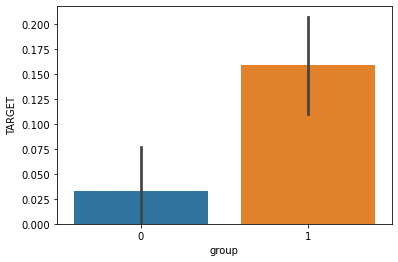

In [184]:
sns.barplot('group', 'TARGET', data=full)

#### 하위 25%의 고객이 상위 75%보다 상환 가능성이 더 높은 것을 알 수 있음